Install packages

In [1]:
!pip install dash

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 7.3 MB 13.9 MB/s eta 0:00:01
     |████████████████████████████████| 95 kB 14.0 MB/s  eta 0:00:01
     |████████████████████████████████| 357 kB 81.0 MB/s eta 0:00:01
  Created wheel for dash-core-components: filename=dash_core_components-2.0.0-py3-none-any.whl size=3803 sha256=a57ab9b04362229c23d46228a925d2660f34929b37fa05f4e2e41519af88e347
  Stored in directory: /hkfs/home/project/haicore-project-ws-hip-2021/gfz_wrona/.cache/pip/wheels/52/e4/f3/16724791571a955a46d54650510c98c04ab7d339626aee27cc
  Created wheel for dash-html-components: filename=dash_html_components-2.0.0-py3-none-any.whl size=4071 sha256=9db8931a3c66461893a8d8679cff14b9ff398a0ead30490b61f8859b11af4a44
  Stored in directory: /hkfs/home/project/haicore-project-ws-hip-2021/gfz_wrona/.cache/pip/wheels/73/d8/8d/92f612c03c895f19bcc56a6c54be7bb41aaa698012a5624f60
  Created wheel for dash-table: filename=dash

In [2]:
!git clone https://github.com/stefanknegt/Probabilistic-Unet-Pytorch.git

fatal: destination path 'Probabilistic-Unet-Pytorch' already exists and is not an empty directory.


In [3]:
import sys
sys.path.append('Probabilistic-Unet-Pytorch/')

Download seismic and interpretations:

In [6]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1-gpxnUcvLKhn43CJdzjyAotDPj18pydD',
                                    dest_path='./interp.db',
                                    unzip=False)

gdd.download_file_from_google_drive(file_id='1JqqYbaryyUBsgWVwzLu_PStpnhGarI5q',
                                    dest_path='./S1.jpg',
                                    unzip=False)

Load packages

In [9]:
import dash
import json
import os.path
import time
import random
import math
from dash import dcc
import dash_html_components as html
import numpy as np
from os import path
from PIL import Image
from scipy import sparse
from scipy.stats import uniform
from sqlalchemy import MetaData, Table, Column, String
from sqlalchemy import Integer, create_engine, select
from dash.dependencies import Input, Output, State
from dash_table import DataTable
from dash.exceptions import PreventUpdate

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from datetime import datetime

/scratch/slurm_tmpdir/job_1526892/ipykernel_1755657/1264867696.py:17: UserWarning: 
The dash_table package is deprecated. Please replace
`import dash_table` with `from dash import dash_table`

Also, if you're using any of the table format helpers (e.g. Group), replace 
`from dash_table.Format import Group` with 
`from dash.dash_table.Format import Group`
  from dash_table import DataTable


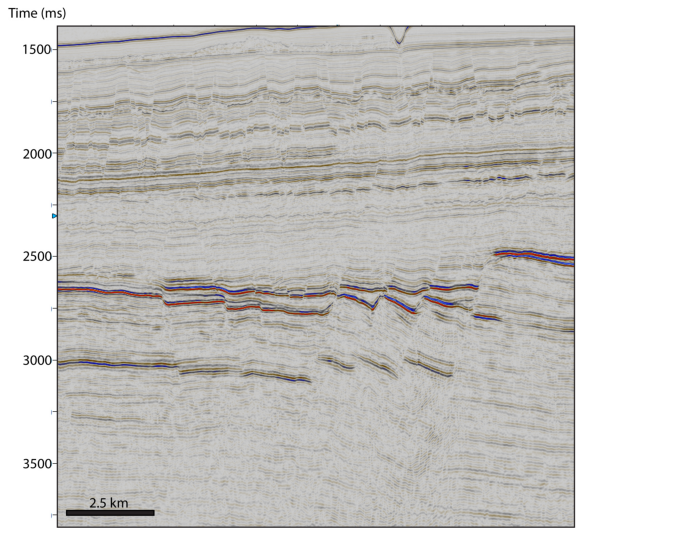

In [221]:
seismic = mpimg.imread('S1.jpg')


plt.figure(figsize=(12,12))
plt.imshow(seismic)
plt.axis('off')
plt.show()

Connect database:

In [223]:
metadata = MetaData()
clean_data_table = Table('interps', metadata,
                    Column('id', Integer, primary_key=True),
					          Column('num', Integer),
                    Column('experience', Integer),
                    Column('sparserow', String(1e6)),
                    Column('sparsecol', String(1e6)),
					          Column('timetaken', String(30)),
					          Column('image', String(3)))

engine = create_engine("sqlite:///interp.db")
metadata.create_all(engine)
conn = engine.connect()

Get interpretations from different interpreters:

In [224]:
inimg = 'S1'

resx = seismic.shape[0]
resy = seismic.shape[1]
select_stmt = select([clean_data_table.c.sparserow, clean_data_table.c.sparsecol]).where(clean_data_table.c.image == inimg)
conn = engine.connect()
result = conn.execute(select_stmt)

interpretations = []
for row in result:

  interpretation = np.zeros((resx, resy))

  maskrow = np.array(row.sparserow.split(',')).astype(int)
  maskcol = np.array(row.sparsecol.split(',')).astype(int)
  for i in range(len(maskrow)):
    interpretation[maskrow[i]][maskcol[i]] += 1

  interpretations.append(interpretation[75:1620, 180:1980])



Let's crop the images consistently:

In [225]:
seismic = seismic[75:1620, 180:1980]

In [226]:
seismic = (seismic-np.min(seismic))/(np.max(seismic)-np.min(seismic))

Look at data:

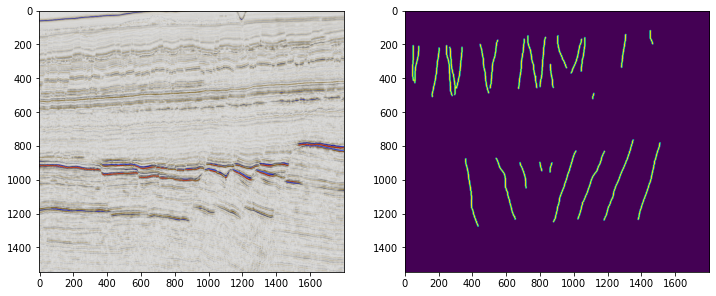

In [227]:
fig, axs = plt.subplots(1,2, figsize=(12,12))

axs[0].imshow(seismic)
axs[1].imshow(interpretations[0])
plt.show()

Create dataset for training:

In [177]:
def patchify(data, label, size, number, threshold):

    (t_max, x_max) = label.shape    
    X = np.zeros((number, size, size, 1))
    Y = np.zeros((number, size, size, 1))
        
    n = 0
    while n < number: 
        x = random.randint(size//2, x_max-size//2)
        t = random.randint(size//2, t_max-size//2)
        if np.count_nonzero(label[t-size//2:t+size//2, x-size//2:x+size//2]) > threshold:
            X[n,:,:,0]  = data[t-size//2:t+size//2, x-size//2:x+size//2]
            Y[n,:,:,0]  = label[t-size//2:t+size//2, x-size//2:x+size//2]
            n = n + 1
    return X, Y


# Parameters
batch_size = 32
size         = 128
threshold    = 0
num_examples = 10000
num_sections = len(interpretations)
val_split = 0.8

X = np.zeros((num_examples,size,size,1))
Y = np.zeros((num_examples,size,size,1))


n = 0
for interpretation in interpretations:
  X[n:num_examples//num_sections,...], Y[n:num_examples//num_sections,...] = patchify(seismic[:,:,0], interpretation, size, num_examples//num_sections, threshold)


X_train = X[:int(val_split*num_examples),...]
Y_train = Y[:int(val_split*num_examples),...]

X_val = X[int(val_split*num_examples):,...]
Y_val = Y[int(val_split*num_examples):,...]



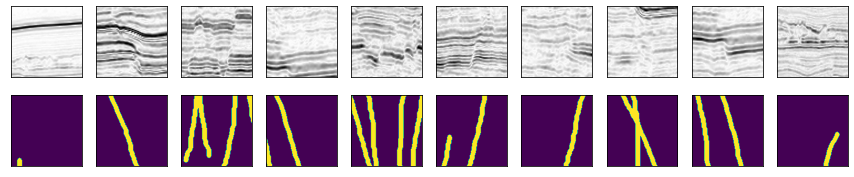

In [178]:
fig, axs = plt.subplots(2, 10, figsize=(15,3))

k = 0
for m in range(10):
  axs[0,m].imshow(X_train[k,:,:,0], interpolation='spline16', cmap=plt.cm.gray, aspect=1)
  axs[0,m].set_xticks([])
  axs[0,m].set_yticks([])
  k += 1

k = 0
for m in range(10):
  axs[1,m].imshow(Y_train[k,:,:,0], interpolation='spline16', aspect=1)
  axs[1,m].set_xticks([])
  axs[1,m].set_yticks([])
  k += 1


In [179]:
X_train = torch.Tensor(X_train).permute(0, 3, 1, 2)
Y_train = torch.Tensor(Y_train).permute(0, 3, 1, 2)
X_val = torch.Tensor(X_val).permute(0, 3, 1, 2)
Y_val = torch.Tensor(Y_val).permute(0, 3, 1, 2)

train_tensors = torch.cat((X_train, Y_train), 1)
val_tensors = torch.cat((X_val, Y_val), 1)

train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_val, Y_val)

train_loader = DataLoader(train_dataset, batch_size = batch_size)
val_loader = DataLoader(val_dataset, batch_size = batch_size)

In [180]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [181]:
from probabilistic_unet import ProbabilisticUnet
from utils import l2_regularisation
from tqdm.auto import tqdm, trange

In [182]:
class Logger(object):
    def __init__(self):
        self.metrics = ['elbo', 'reconstruction_loss', 'mse_loss', 'std', 'kl diveregence', 'reg_loss']
        self.lists = [[], [], [], [], [], []]
        self.steps = []
    def step(self, global_step, *args):
        for i, value in enumerate(args):
            self.lists[i].append(value.item())
        self.steps.append(global_step)

In [183]:
net = ProbabilisticUnet(input_channels=1, 
                        num_classes=1, 
                        num_filters=[8,16,32,64], 
                        latent_dim=4, 
                        no_convs_fcomb=2, 
                        beta=1.0)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-5, weight_decay=0)
global_step = 0
epochs = 200
nsamples = 64
mse_criteria = nn.MSELoss()
logger = Logger()
loggerVal = Logger()

def compute_stats(mask):
    mean_pred = torch.zeros_like(mask)
    mean_sq_pred = torch.zeros_like(mask)
    for _ in range(nsamples):
        pred = net.sample().detach()
        mean_pred += pred
        mean_sq_pred += pred**2
    mean_pred /= nsamples
    mean_sq_pred /= nsamples
    var_pred = (mean_sq_pred - mean_pred**2)
    mse = mse_criteria(mask, mean_pred)
    std = var_pred.mean()**0.5
    return mse, std
    
for epoch in trange(epochs, desc = 'epochs'):
    for step in trange(len(train_loader), desc='batches', leave=False):
        patch, mask = next(iter(train_loader))
        patch = patch.to(device)
        mask = mask.to(device)
        net(patch, mask, training=True)
        elbo = net.elbo(mask)
        reg_loss = l2_regularisation(net.posterior) + l2_regularisation(net.prior) + l2_regularisation(net.fcomb.layers)
        loss = -elbo + 1e-5 * reg_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if global_step % save_every_steps == 0:
            mse, std = compute_stats(mask)
            logger.step(global_step, elbo, net.reconstruction_loss, mse, std, net.kl, reg_loss)
            
            patch, mask = next(iter(val_loader))
            patch = patch.to(device)
            mask = mask.to(device)
            net(patch, mask, training=False)
            elbo = net.elbo(mask).detach()
            reg_loss = l2_regularisation(net.posterior) + l2_regularisation(net.prior) + l2_regularisation(net.fcomb.layers)
            loss = -elbo + 1e-5 * reg_loss
            mse, std = compute_stats(mask)
            loggerVal.step(global_step, elbo, net.reconstruction_loss, mse, std, net.kl, reg_loss)
        global_step += 1

epochs:   0%|          | 0/200 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

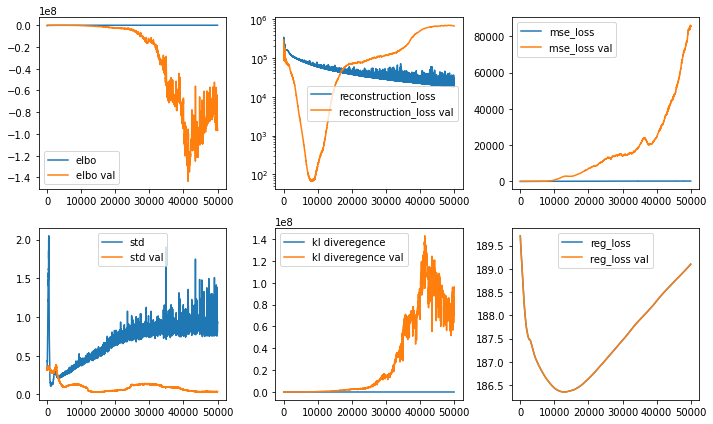

In [184]:
ncols = 3
nrows = len(logger.metrics) // ncols
fig, axs = plt.subplots(figsize = (10, 6), ncols = ncols, nrows = nrows)
for i, name in enumerate(logger.metrics):
    axs.flatten()[i].plot(logger.steps, logger.lists[i], label = name)
    axs.flatten()[i].plot(loggerVal.steps, loggerVal.lists[i], label = name+' val')
    if name in ['kl divergence', 'reconstruction_loss']:
        axs.flatten()[i].set_yscale('log')
    axs.flatten()[i].legend()
plt.tight_layout()

In [185]:
patch, mask = next(iter(train_loader))
net.forward(patch.to(device), None, training=False)

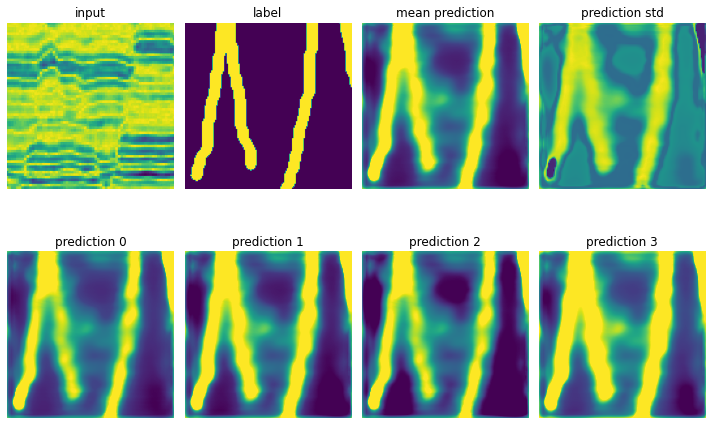

In [186]:
i = np.random.randint(batch_size)

nsamples = 4
ncols = 4
nrows = int(np.ceil((nsamples+3) / ncols))

pred_mask = net.sample().detach().cpu()
vmin = torch.quantile(pred_mask, 0.1)
vmax = torch.quantile(pred_mask, 0.9)

fig, axs = plt.subplots(figsize = (10, 7), ncols = ncols, nrows = nrows)
axs.flatten()[0].imshow(patch[i,0])
axs.flatten()[0].axis('off')
axs.flatten()[0].set_title('input')
axs.flatten()[1].imshow(mask[i,0])
axs.flatten()[1].axis('off')
axs.flatten()[1].set_title('label')

mean_pred = torch.zeros_like(mask)
mean_sq_pred = torch.zeros_like(mask)
for j in range(nsamples):
    pred_mask = net.sample().detach().cpu()
    mean_pred += pred_mask
    mean_sq_pred += pred_mask**2
    axs.flatten()[j+4].imshow(pred_mask[i,0], vmin = vmin, vmax = vmax)
    axs.flatten()[j+4].axis('off')
    axs.flatten()[j+4].set_title(f'prediction {j:d}')
mean_pred /= nsamples
mean_sq_pred /= nsamples
var_pred = (mean_sq_pred - mean_pred**2)
std = var_pred**0.5


axs.flatten()[2].imshow(mean_pred[i,0], vmin = vmin, vmax = vmax)
axs.flatten()[2].axis('off')
axs.flatten()[2].set_title(f'mean prediction')

axs.flatten()[3].imshow(std[i,0])
axs.flatten()[3].axis('off')
axs.flatten()[3].set_title(f'prediction std')

plt.tight_layout()

In [433]:
def tile(data, wsize, dt, dx):
    
    (t_max, x_max) = data.shape    
    
    n_patch = (t_max//dt+1)*(x_max//dx+1)
    data_patch = np.zeros((n_patch,wsize,wsize,1)) 

    n = 0
    for t in range(0, t_max, dt):
        for x in range(0, x_max, dx):    
            if t_max - t < wsize and x_max - x < wsize:
                data_patch[n,:,:,0] = data[t_max-wsize:t_max, x_max-wsize:x_max]
            elif x_max - x < wsize:
                data_patch[n,:,:,0] = data[t:t+wsize, x_max-wsize:x_max]
            elif t_max - t < wsize:
                data_patch[n,:,:,0] = data[t_max-wsize:t_max, x:x+wsize]
            else:
                data_patch[n,:,:,0] = data[t:t+wsize,x:x+wsize]  
            n = n + 1
    
    return data_patch 




def merge(data_patch, t_max, x_max, wsize, dt, dx):

    data_new = np.zeros((t_max, x_max,1))
    count = np.zeros((t_max, x_max, 1))
    
    n = 0
    for t in range(0, t_max, dt):
        for x in range(0, x_max, dx):
            if t_max - t < wsize and x_max - x < wsize:
                data_new[t_max-wsize:t_max, x_max-wsize:x_max,0] += data_patch[n,:,:,0]
                count[t_max-wsize:t_max, x_max-wsize:x_max,0] += 1
            elif x_max - x < wsize:
                data_new[t:t+wsize, x_max-wsize:x_max,0] += data_patch[n,:,:,0]
                count[t:t+wsize, x_max-wsize:x_max,0] += 1 
            elif t_max - t < wsize:
                data_new[t_max-wsize:t_max, x:x+wsize,0] += data_patch[n,:,:,0]
                count[t_max-wsize:t_max, x:x+wsize,0] += 1
            else:
                data_new[t:t+wsize,x:x+wsize,0] += data_patch[n,:,:,0]
                count[t:t+wsize,x:x+wsize,0] += 1 
            n = n + 1

    return data_new/count


dt = 128
dx = 128

size = 128

t_max, x_max, a = seismic.shape


data_tiles   = tile(seismic[:,:,1], size, dt, dx)
patch = torch.tensor(data_tiles)
patch = patch.float()
patch = torch.Tensor(patch).permute(0, 3, 1, 2)

net.forward(patch.to(device), None, training=False)

tiles_1 = net.sample().detach().cpu()

tiles_10 = torch.zeros_like(patch)
for j in range(10):
    tiles = net.sample().detach().cpu()
    tiles_10 = tiles_10 + tiles
tiles_10 /= 10
    
    
tiles_100 = torch.zeros_like(patch)
for j in range(100):
    tiles = net.sample().detach().cpu()
    tiles_100 = tiles_100 + tiles  
tiles_100 /= 100


tiles_1 = torch.Tensor(tiles_1).permute(0, 2, 3, 1)
tiles_1 = np.array(tiles_1)

tiles_10 = torch.Tensor(tiles_10).permute(0, 2, 3, 1)
tiles_10 = np.array(tiles_10)

tiles_100 = torch.Tensor(tiles_100).permute(0, 2, 3, 1)
tiles_100 = np.array(tiles_100)

result       = merge(tiles_100, t_max, x_max, size, dt, dx)


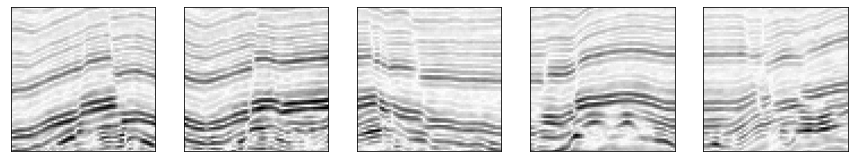

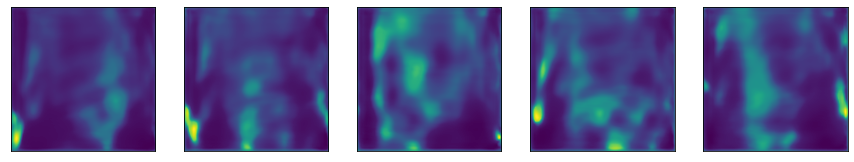

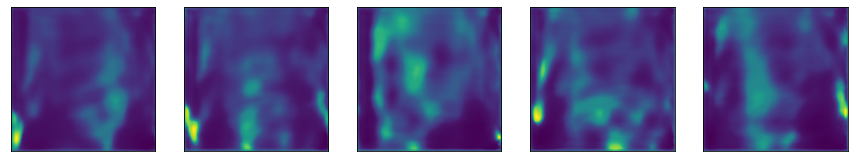

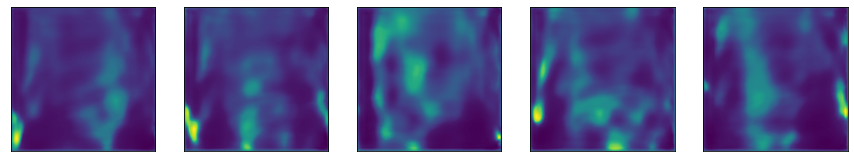

In [434]:
fig, axs = plt.subplots(1, 5, figsize=(15,6))
for m in range(5):
  axs[m].imshow(patch[m+20,0,:,:], interpolation='spline16', cmap=plt.cm.gray, aspect=1)
  axs[m].set_xticks([])
  axs[m].set_yticks([])
plt.show()



fig, axs = plt.subplots(1, 5, figsize=(15,6))
for m in range(5):
  axs[m].imshow(tiles_1[m+20,:,:,0], interpolation='spline16', aspect=1)
  axs[m].set_xticks([])
  axs[m].set_yticks([])    
plt.show()


fig, axs = plt.subplots(1, 5, figsize=(15,6))
for m in range(5):
  axs[m].imshow(tiles_10[m+20,:,:,0], interpolation='spline16', aspect=1)
  axs[m].set_xticks([])
  axs[m].set_yticks([])    
plt.show()


fig, axs = plt.subplots(1, 5, figsize=(15,6))
for m in range(5):
  axs[m].imshow(tiles_100[m+20,:,:,0], interpolation='spline16', aspect=1)
  axs[m].set_xticks([])
  axs[m].set_yticks([])    
plt.show()

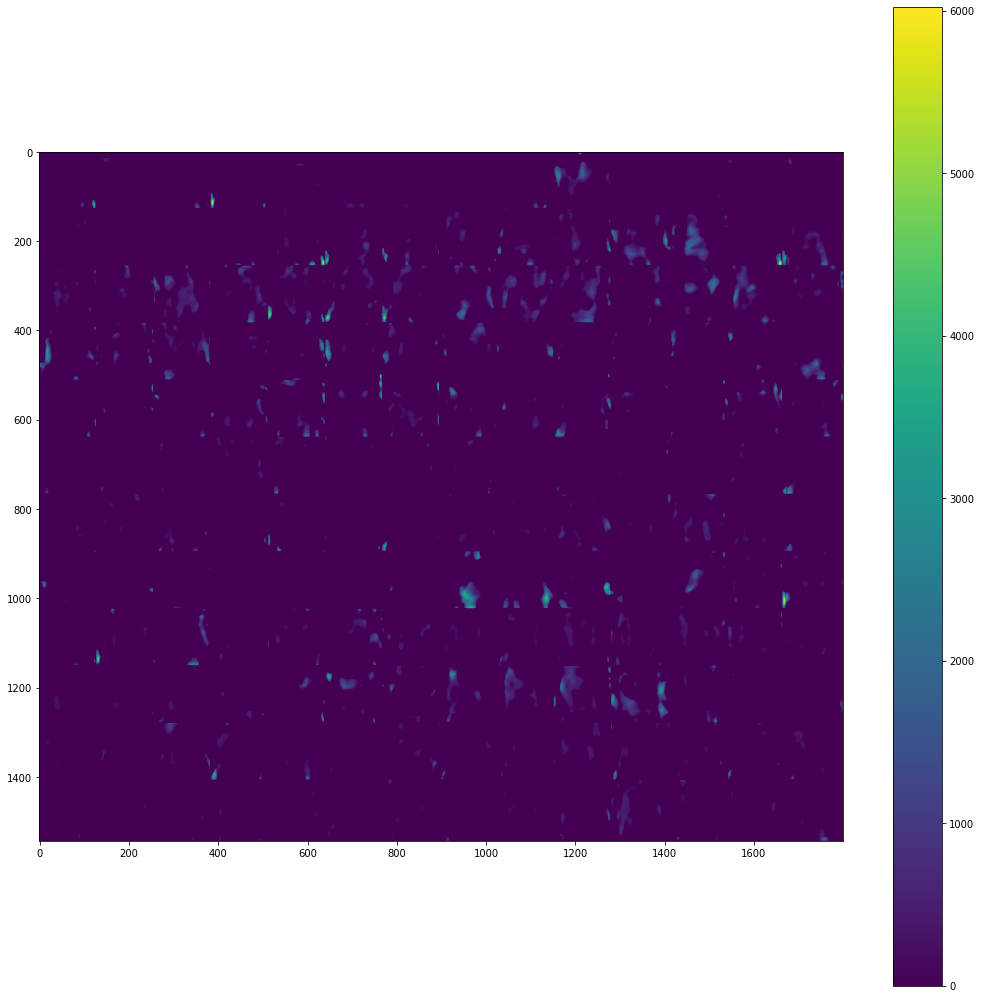

In [424]:
plt.figure(figsize=(18,18))
#plt.imshow(seismic)
plt.imshow(result, cmap='viridis', vmin=0)
plt.colorbar()
plt.show()